# Prediction of Molecular Pathways and Key Mutations

Click to open in: \[[GitHub](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/inference-pipelines/idars.ipynb)\]\[[Colab](https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/develop/examples/inference-pipelines/idars.ipynb)\]



## About this notebook

This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory. To connect with Colab, click on one of the two blue checkboxes above. Check that "colab" appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on GitHub or Colab, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab, set up your Python environment, as explained in the
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.



## About this demo

Prediction of molecular pathways and key mutations directly from Haematoxylin and Eosin stained histology images can help bypass additional genetic (e.g., polymerase chain reaction or PCR) or immunohistochemistry (IHC) testing, which can therefore save both money and time.

In this example notebook, we show how you can use pretrained models to reproduce the inference results obtained by [Bilal et al.](<https://www.thelancet.com/journals/landig/article/PIIS2589-7500(2100180-1/fulltext>)

In this paper, an Iterative Draw and Rank Sampling (IDaRS) approach is proposed, which consists of a two-stage approach:

1. Patch-level tumour classification
1. Patch-level WSI classification

In stage 1, we use a pretrained tumour segmentation model to identify potentially diagnositc areas. In stage 2, we make a task-specific prediction for each tumour patch. For stage 2, the model is trained utilising only the slide-level label and hence the model does not require any detailed annotations at the cell or region level. Here, representative tiles from each WSI are iteratively sampled, which gives justification for the name IDaRS.

In TIAToolbox, we include models that are capable of predicting:

- Microsatellite instability (MSI)
- Hypermutation density
- Chromosomal instability
- CpG island methylator phenotype (CIMP)-high prediction
- BRAF mutation
- TP53 mutation

## Available models

In line with the above description, in TIAToolbox, we provide the following pretrained models used as part of the [original publication](<https://www.thelancet.com/journals/landig/article/PIIS2589-7500(2100180-1/fulltext>).

- Tumour segmentation
  - `resnet18-idars-tumour`
- Task specific prediction
  - MSI: `resnet34-idars-msi`
  - Hypermutation density: `resnet34-idars-hm`
  - Chromosomal instability: `resnet34-idars-cin`
  - CpG island methylator phenotype (CIMP)-high prediction: `resnet34-idars-cimp`
  - BRAF mutation: `resnet34-idars-braf`
  - TP53 mutation: `resnet34-idars-tp53`

The provided models are trained on the first fold used in the original paper.



## Setting up the environment

### TIAToolbox and dependencies installation

You can skip the following cell if 1) you are not using the Colab plaform or 2) you are using Colab and this is not your first run of the notebook in the current runtime session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab , the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)



In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail -n 1
!pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@develop | tail -n 1
print("Installation is done.")

**IMPORTANT**: If you are using Colab and you run the cell above for the first time, note that you need to restart the runtime. To do this, you can either click on the message that appears above this cell, or use Colab's Runtime menu. After restarting the Runtime, you can use the notebook normally, for example using *Runtime→Run All*, or running the cells one-by-one.



### GPU or CPU runtime

Processes in this notebook can be accelerated by using a GPU. Therefore, whether you are running this notebook on your system or Colab, you need to check and specify if you are using GPU or CPU hardware acceleration. In Colab, you need to make sure that the runtime type is set to GPU in the *"Runtime→Change runtime type→Hardware accelerator"*. If you are *not* using GPU, consider changing the `ON_GPU` flag to `False` value, otherwise, some errors will be raised when running the following cells.



In [2]:
ON_GPU = True
"""ON_GPU should be True if cuda-enabled GPU is 
available and False otherwise """
WORKERS = 0
if ON_GPU:
    WORKERS = 8

### Removing leftovers from previous runs

The cell below removes a `tmp` directory that may have been generated in a previous run.



In [3]:
import warnings
import os
import shutil

warnings.filterwarnings("ignore")
save_dir = "./tmp/"


def rmdir(dir_path):
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    print("deleting ", dir_path)


rmdir(save_dir)  # remove `save_dir` if it exists from a previous run
os.mkdir(save_dir)
print("creating new", save_dir, "for downloaded and newly created files")

deleting  ./tmp/
creating new ./tmp/ for downloaded and newly created files


### Importing related libraries

We import some standard Python modules, and also the Python module `wsireader` (see [details](https://github.com/TIA-Lab/tiatoolbox/blob/master/tiatoolbox/wsicore/wsireader.py)) written by the TIA Centre team.



In [4]:
from tiatoolbox.models.engine.patch_predictor import PatchPredictor
from tiatoolbox.utils.misc import imwrite
from tiatoolbox.wsicore.wsireader import WSIReader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 140  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode

### Downloading the required files

We download, over the internet, image files used for the purpose of this notebook. In particular, we download a whole slide image of cancerous colon tissue to highlight how the pipeline works.

In Colab, if you click the files icon (see below) in the vertical toolbar on the left hand side then you can see all the files which the code in this notebook can access. The data will appear here when it is downloaded.

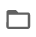



In [5]:
import requests

wsi_file_name = save_dir + "sample_wsi.svs"
print("Download has started. Please wait...")

# Downloading sample TCGA whole-slide image
r = requests.get(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-AD-6964-01Z-00-DX1.83AF88B9-C59B-48C6-A739-85ACB8F8ECA9.svs"
)
with open(wsi_file_name, "wb") as f:
    f.write(r.content)

print("Download is complete.")

Download has started. Please wait...
Download is complete.


## Tumour segmentation using TIAToolbox pretrained models

In this section, we will display patch-level tumour segmentation results using a pretrained model used in the original paper by Bilal _et al_. In particular, this model is a ResNet model with 18 layers (resnet18). A prediction is made for each input patch, which denotes the probability of being tumour.

> More information on the model and the dataset used for training can be found [here](<https://www.thelancet.com/journals/landig/article/PIIS2589-7500(2100180-1/fulltext>).

In line with the patch prediction model provided in `tiatoolbox`, the tumour segmentation model can be applied to input patches, large images tiles or whole-slide images. In order to replicate the original pipeline, we choose to process a sample whole-slide image. It can be seen that we can perform inference on a WSI with minimal effort. First we create the `PatchPredictor` object, which denotes the pretrained model that we will use, along with other arguments, such as the batch size and number of workers. Then, we call the `predict` method to process the slide and return the results. More information on using the `PatchPredictor` functionality can be seen in the dedicated patch prediction notebook.



In [6]:
wsi_file_list = [
    wsi_file_name
]  # the list of WSIs to process- in this example we just use a single WSI.

In [7]:
tumour_predictor = PatchPredictor(
    pretrained_model="resnet18-idars-tumour", batch_size=64, num_loader_workers=WORKERS
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet18-idars-tumour.pth
Save to /root/.tiatoolbox/models/resnet18-idars-tumour.pth


In [8]:
tumour_output = tumour_predictor.predict(
    imgs=wsi_file_list, mode="wsi", return_probabilities=True, on_gpu=ON_GPU
)

100%|###########################################| 24/24 [02:32<00:00,  6.35s/it]


As can be seen above, with just a few lines of code we are able to perform tumour segmentation on whole-slide images. When running the prediction, as we did above, the default parameters for `patch_shape`, `stride_shape` and `resolution` will be used. Here, `patch_shape`, and `resolution` are in line with what was used for training the model, whereas `stride_shape` is set to be equal to the `patch_shape` (no overlap). In particular, the input patch size is 512x512 and the processing resolution is 0.5 microns per pixel (~20x objective magnification).

If you want to change the default parameters, you will need to define this using `IOPatchPredictorConfig`. For example, you may want to run with 50% overlap between neighbouring patches. Therefore, you would define:

```
wsi_ioconfig = IOPatchPredictorConfig(
    input_resolutions=[{'units': 'mpp', 'resolution': 0.5}],
    patch_input_shape=[512, 512],
    stride_shape=[256, 256],
)
```

Then, you would add this in the `predict` method as follows:

```
tumour_output = tumour_predictor.predict(
    imgs=[wsi_file_name],
    mode='wsi',
    return_probabilities=True,
    on_gpu=True
    ioconfig=wsi_ioconfig)
```

Below, we show how to merge the output predictions to form a 2-dimensional prediction map, denoting areas predicted as tumour. This prediction map is used in the second step of the pipeline, where we use only patches containing tumour.



In [9]:
overview_resolution = 1.25  # the resolution in which we desire to merge and visualize the patch predictions
overview_unit = "power"  # the unit of the `resolution` parameter. Can be "power", "level", "mpp", or "baseline"

# merge predictions to form a 2-dimensional output at the desired resolution
tumour_mask = tumour_predictor.merge_predictions(
    wsi_file_name, tumour_output[0], resolution=overview_resolution, units=overview_unit
)

# the output map will contain values from 0 to 2.
# 0: background that is not processed, 1: non-tumour prediction and 2 is tumour predictions
tumour_mask = tumour_mask == 2  # binarise the output

# let's save the tumour mask, so that we can use it in stage 2!
imwrite(save_dir + "tumour_mask.png", tumour_mask.astype("uint8") * 255)

Now that we have merged the prediction, let's visualise the results!



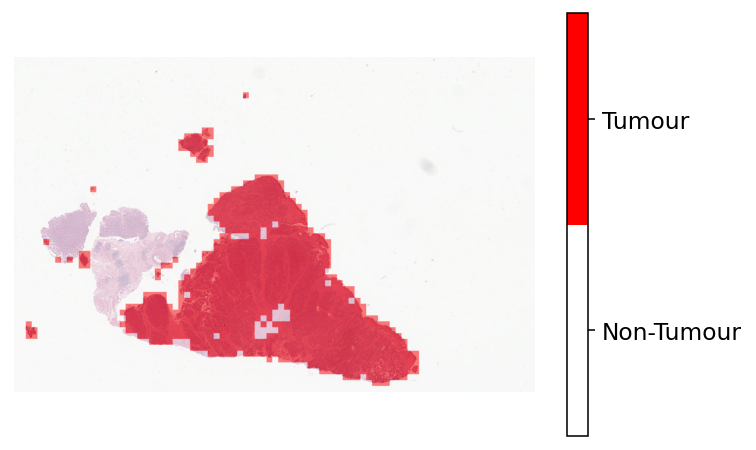

In [10]:
from tiatoolbox.utils.visualization import overlay_prediction_mask

# first read the WSI at a low-resolution. Here, we use the same resolution that was used when merging the patch-level results.
wsi = WSIReader.open(wsi_file_name)
wsi_overview = wsi.slide_thumbnail(resolution=overview_resolution, units=overview_unit)

# [Overlay map creation]
# creating label-color dictionary to be fed into `overlay_prediction_mask` function to help generate a color legend
label_dict = {"Non-Tumour": 0, "Tumour": 1}
label_color_dict = {}
colors = [[255, 255, 255], [255, 0, 0]]  # defining colours for overlay (white and red)
for class_name, label in label_dict.items():
    label_color_dict[label] = (class_name, np.array(colors[label]))

overlay = overlay_prediction_mask(
    wsi_overview, tumour_mask, alpha=0.5, label_info=label_color_dict
)
plt.show()

## WSI prediction using TIAToolbox pretrained models

Next, we show how one can use a second CNN that takes as input the results obtained from part 1 and gives a prediction for each tumour patch in the input WSI. In the original paper, 4 fold cross validation was used. In the toolbox, we choose to provide models trained on the first fold of the data, which enables us to cross check the results and ensure that they are in line with the original work. All models in the second step of the pipeline are ResNet34.

To speed up this step, we choose to retrain the models without stain normalization (as oppoed to the original IDaRS) and instead with colour jitter. We report the difference in results at the end of this notebook.

Near the beginning of the notebook, we mention which prediction tasks we consider. Next, we will run inference for all of these prediction tasks and visualise the output.



In [11]:
# Run inference for each of the 6 WSI prediction tasks
prediction_tasks = ["msi", "braf", "cimp", "cin", "hm", "tp53"]

# iterate over each of the prediction tasks and add the results to a dictionary
wsi_output_dict = {}
for task in prediction_tasks:
    wsi_predictor = PatchPredictor(
        pretrained_model="resnet34-idars-%s" % task,
        batch_size=64,
        num_loader_workers=WORKERS,
    )

    # we include the obtained tumour mask from stage 1 as an argument so that we only process patches from those regions.
    wsi_output_dict[task] = wsi_predictor.predict(
        imgs=wsi_file_list,
        masks=[save_dir + "tumour_mask.png"],
        mode="wsi",
        return_probabilities=True,
        on_gpu=ON_GPU,
    )

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet34-idars-msi.pth
Save to /root/.tiatoolbox/models/resnet34-idars-msi.pth


100%|###########################################| 22/22 [01:36<00:00,  4.37s/it]


Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet34-idars-braf.pth
Save to /root/.tiatoolbox/models/resnet34-idars-braf.pth


100%|###########################################| 22/22 [01:37<00:00,  4.43s/it]


Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet34-idars-cimp.pth
Save to /root/.tiatoolbox/models/resnet34-idars-cimp.pth


100%|###########################################| 22/22 [01:38<00:00,  4.46s/it]


Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet34-idars-cin.pth
Save to /root/.tiatoolbox/models/resnet34-idars-cin.pth


100%|###########################################| 22/22 [01:36<00:00,  4.37s/it]


Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet34-idars-hm.pth
Save to /root/.tiatoolbox/models/resnet34-idars-hm.pth


100%|###########################################| 22/22 [01:36<00:00,  4.37s/it]


Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet34-idars-tp53.pth
Save to /root/.tiatoolbox/models/resnet34-idars-tp53.pth


100%|###########################################| 22/22 [01:35<00:00,  4.32s/it]


Now that we have performed patch-level classification for each tumour patch, let's merge together the results to get the 2D prediction map. Here, we return the raw probability map, rather than the class predictions. We do this because the final step in the IDaRS pipeline uses the raw patch-level probabilities to classify each WSI.



In [12]:
overview_resolution = 1.25  # the resolution in which we desire to merge and visualize the patch predictions
overview_unit = "power"  # the unit of the `resolution` parameter. Can be "power", "level", "mpp", or "baseline"

# merge predictions to form a 2-dimensional output at the desired resolution
merged_output_dict = {}
for task in prediction_tasks:
    merged_output = PatchPredictor.merge_predictions(
        wsi_file_name,
        wsi_output_dict[task][0],
        resolution=overview_resolution,
        units=overview_unit,
        return_raw=True,
    )
    merged_output_dict[task] = merged_output[..., 1]  # consider only the positive class

Now that we have merged the predictions to obtain the probability map, let's visualise the results. This is very similar to the `overlay_patch_prediction` function, but `label_info` does not need to be provided because we only have one class. Also, `min_val` can be provided. This is a number between 0 and 1 which ensures that the probability map is only shown for values greater than `min_val`.



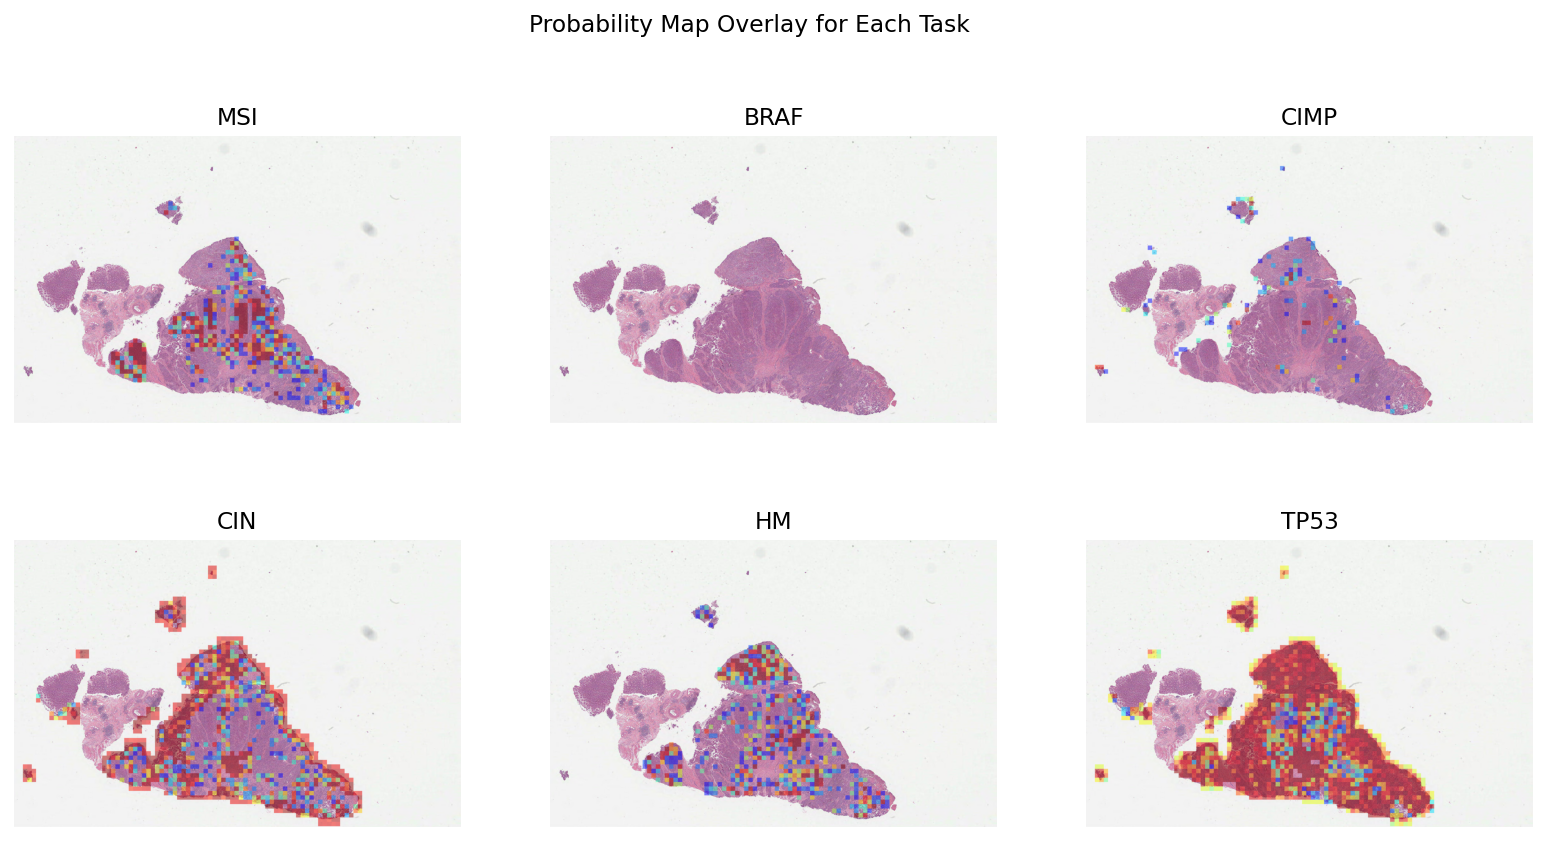

In [13]:
from tiatoolbox.utils.visualization import overlay_probability_map

# [Overlay map creation]
# iterate over the tasks and generate the probability map
overlay_list = []
for task in prediction_tasks:
    # only show the probability map when it is greater than `min_val` (0.1 is used here)
    overlay_prob_map = overlay_probability_map(
        wsi_overview, merged_output_dict[task], alpha=0.5, min_val=0.1, return_ax=False
    )
    overlay_list.append(overlay_prob_map)

# visualise the overlays in a single plot
fig = plt.figure(figsize=(14, 7))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(overlay_list[i])
    plt.axis("off")
    plt.title(prediction_tasks[i].upper())
fig.suptitle("Probability Map Overlay for Each Task")

plt.show()

These probability maps can be used to increase the interpretability of results and help identify regions contributing to the overall prediction. To get a smoother output, you can increase the overlap by modifying `IOPatchPredictorConfig`.

Let's visualise some patches that have either a high probability or a low probability of being MSI positive. For this, we randomly sample 4 patches with probability of being MSI > 0.95 and 4 patches with probability of being MSI \< 0.05.



In [14]:
# get the probabilities of each processed patch being MSI
msi_probabilities = wsi_output_dict["msi"][0]["probabilities"]
msi_probabilities = np.array(msi_probabilities)[..., 1]

# get the coordinates of each processed patch
msi_coordinates = wsi_output_dict["msi"][0]["coordinates"]
msi_coordinates = np.array(msi_coordinates)

# subset where MSI probability is greater than 0.95
msi_probabilities_subset_pos = msi_probabilities[msi_probabilities > 0.95]
msi_coordinates_subset_pos = msi_coordinates[msi_probabilities > 0.95]

# subset where MSI probability is less than than 0.05
msi_probabilities_subset_neg = msi_probabilities[msi_probabilities > 0.05]
msi_coordinates_subset_neg = msi_coordinates[msi_probabilities > 0.05]
msi_coordinates_subset = list(msi_coordinates_subset_pos) + list(
    msi_coordinates_subset_neg
)

# randomly sample 4 positive and 4 negative
random_pos_idx = np.random.randint(0, msi_probabilities_subset_pos.shape[0], size=4)
random_neg_idx = np.random.randint(0, msi_probabilities_subset_neg.shape[0], size=4)
random_idx = list(random_pos_idx) + list(random_neg_idx)

Now that we have obtained our random sample, let's plot the patches! First, we use TIAToolbox's `WSIReader` to read the original WSI and extract patches at defined locations. For detailed information on this, see the relevant example notebook!



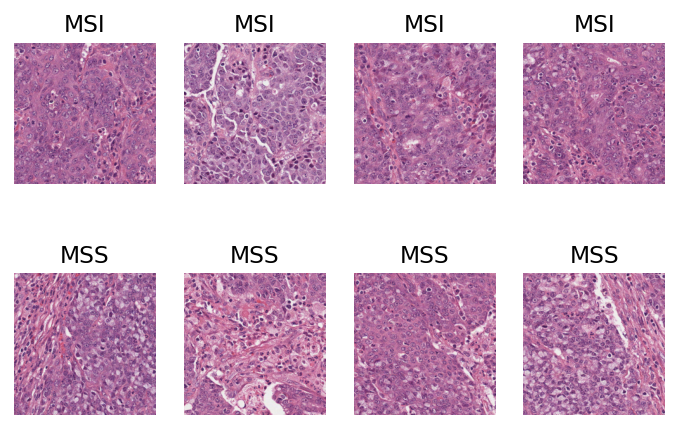

In [15]:
# read the WSI and get the resolution used during processing.
wsi_reader = WSIReader.open(input_img=wsi_file_name)
resolution = wsi_output_dict["msi"][0]["resolution"]
units = wsi_output_dict["msi"][0]["units"]

# visualise the overlays in a single plot
fig = plt.figure()
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    coords = msi_coordinates_subset[random_idx[i]]
    size = (
        coords[2] - coords[0],
        coords[3] - coords[1],
    )  # determine the size of patch from the coordinates
    # get the patch
    patch = wsi_reader.read_rect(
        (coords[0] * 4, coords[1] * 4), size, resolution=resolution, units=units
    )
    plt.imshow(patch)
    plt.axis("off")
    if i < 4:
        plt.title("MSI")
    else:
        plt.title("MSS")
plt.show()

The probability maps are not directly needed to obtain the WSI-level score. Below, we will demonstrate how one can obtain the WSI score utilising the output from the `PatchPredictor` in step 2. For the purpose of this example, we will show how to use mean and max aggregation to obtain a slide-level prediction score.

First, let's examine the format of the dictionary output by `PatchPredictor`. We look only at the MSI output as an example, but the output from each task is similar.



In [16]:
# get the keys of the dictionary returned at the output of the MSI CNNPatchPredictor
print("Output of PatchPredictor:")
print(list(wsi_output_dict["msi"][0].keys()))

Output of PatchPredictor:
['probabilities', 'predictions', 'coordinates', 'label', 'pretrained_model', 'resolution', 'units']


As we can see, the probabilities are returned as output. Now, let's compute, for each task, the average and maximum over all probabilities of tumour tiles being positive.



In [17]:
slide_score_mean = {}
slide_score_max = {}
# iterate over the tasks
for task in prediction_tasks:
    probabilities = np.array(wsi_output_dict[task][0]["probabilities"])[
        ..., 1
    ]  # only consider positive class
    slide_score_mean[task] = np.mean(
        probabilities
    )  # get the average probability over all tumour tiles
    slide_score_max[task] = np.max(
        probabilities
    )  # get the maximum probability over all tumour tiles


# print the scores
print("MEAN AGGREGATION")
for task, value in slide_score_mean.items():
    print(task, ":", value)

print("-" * 30)

print("MAX AGGREGATION")
for task, value in slide_score_max.items():
    print(task, ":", value)

MEAN AGGREGATION
msi : 0.19757115686152246
braf : 0.0012802154157488049
cimp : 0.04703370509433786
cin : 0.49854227295191067
hm : 0.20540336180833144
tp53 : 0.8004594482890646
------------------------------
MAX AGGREGATION
msi : 0.9999943971633911
braf : 0.04610874131321907
cimp : 0.997495174407959
cin : 0.9994856119155884
hm : 0.9999963045120239
tp53 : 0.9997155070304871


As can be seen, it is straight forward to go from the WSI output to the WSI-level prediction score. In a similar way, different aggregation methods can be used, such as top k probabilities. To highlight how easy it is to obtain the slide level score using TIAToolbox, we provide below the code required to go from input to output.

```
# TUMOUR DETECTION
tumour_predictor = PatchPredictor(pretrained_model='resnet18-idars-tumour', batch_size=64)

tumour_output = tumour_predictor.predict(
    imgs=[wsi_file_name],
    mode='wsi',
    return_probabilities=True,
    on_gpu=True)

tumour_mask = tumour_predictor.merge_predictions(
    wsi_file_name,
    tumour_output[0],
    resolution=overview_resolution,
    units=overview_unit)

tumour_mask = tumour_mask == 2 # binarise the output
imwrite(save_dir + 'tumour_mask.png',
    tumour_mask.astype('uint8') * 255)

# WSI PREDICTION
msi_predictor = PatchPredictor(pretrained_model='resnet34-idars-msi', batch_size=64)

msi_output = msi_predictor.predict(
    imgs=[wsi_file_name],
    masks=[save_dir + 'tumour_mask.png'],
    mode='wsi',
    return_probabilities=True,
    on_gpu=True)

# SLIDE-LEVEL SCORE
msi_probabilities = np.array(msi_output[0]['probabilities'])[...,1] # only consider MSI class
average_msi_probability = np.mean(msi_probabilities) # get the average over all tumour tiles
```

We encourage you to play around with the models provided by TIAToolbox for prediction of molecular pathways and key mutations. To make a different WSI level prediction, all you need to do is use a different task-specific pretrained weights in the second `PatchPredictor`.

Below, we report the results obtained with our retrained model compared to the original results. For the purpose of this, we only consider mean aggregation for each task. All results show the area under the receiver operating characteristic curve (AUROC).

| Task | Original | TIAToolbox |
| ---- | -------- | ---------- |
| MSI  | 0.83     | 0.87       |
| TP53 | 0.76     | 0.75       |
| BRAF | 0.81     | 0.75       |
| CIMP | 0.85     | 0.75       |
| CIN  | 0.85     | 0.81       |
| HM   | 0.86     | 0.79       |

